# 第5章 决策树

1．分类决策树模型是表示基于特征对实例进行分类的树形结构。决策树可以转换成一个**if-then**规则的集合，也可以看作是定义在特征空间划分上的类的条件概率分布。

2．决策树学习旨在构建一个与训练数据拟合很好，并且复杂度小的决策树。因为从可能的决策树中直接选取最优决策树是NP完全问题。现实中采用启发式方法学习次优的决策树。

决策树学习算法包括3部分：特征选择、树的生成和树的剪枝。常用的算法有ID3、
C4.5和CART。

3．特征选择的目的在于选取对训练数据能够分类的特征。特征选择的关键是其准则。常用的准则如下：

（1）样本集合$D$对特征$A$的信息增益（ID3）

互信息(mutual information)
$$g(D, A)=H(D)-H(D|A)$$
   熵(entropy):
   $$H(p) = -\sum_{i=1}^{n}p_ilogp_i$$
$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$

   条件熵(conditional entropy):
$$H(Y|X) = \sum_{i=1}^{n}p_iH(Y|X=x_i)$$
这里, $p_i = P(X=x_i), i=1, 2, \cdots, n$
$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$
当熵和条件熵中的概率由数据统计得到时, 所对应的熵和条件熵被称为经验熵(empirical entropy)和经验条件熵(empirical conditional entropy)

其中，$H(D)$是数据集$D$的熵，$H(D_i)$是数据集$D_i$的熵，$H(D|A)$是数据集$D$对特征$A$的条件熵。	$D_i$是$D$中特征$A$取第$i$个值的样本子集，$C_k$是$D$中属于第$k$类的样本子集。$n$是特征$A$取 值的个数，$K$是类的个数。

（2）样本集合$D$对特征$A$的信息增益比（C4.5）


$$g_{R}(D, A)=\frac{g(D, A)}{H_A(D)}$$


其中，$g(D,A)$是信息增益，$H_A(D) = -\sum_{i=1}^{n} \frac{\left|C_{i}\right|}{|D|} \log _{2} \frac{\left|C_{i}\right|}{|D|}$是数据集$D$关于特征A的值的熵。

（3）样本集合$D$的基尼指数（CART）

$$\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2}$$

特征$A$条件下集合$D$的基尼指数(Gini index)：

 $$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}\left(D_{1}\right)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}\left(D_{2}\right)$$
 
4．决策树的生成。通常使用信息增益最大、信息增益比最大或基尼指数最小作为特征选择的准则。决策树的生成往往通过计算信息增益或其他指标，从根结点开始，递归地产生决策树。这相当于用信息增益或其他准则不断地选取局部最优的特征，或将训练集分割为能够基本正确分类的子集。

5．决策树的剪枝(pruning)。由于生成的决策树存在过拟合问题，需要对它进行剪枝，以简化学到的决策树。决策树的剪枝，往往从已生成的树上剪掉一些叶结点或叶结点以上的子树，并将其父结点或根结点作为新的叶结点，从而简化生成的决策树(后减枝). 决策树学习的损失函数定义为:
$$C_\alpha(T) = C(T) + \alpha|T| = \sum_{t=1}^{|T|}N_tH_t(T) + \alpha|T|$$

式中$C(T)$表示模型对训练数据的预测误差, $|T|$为树的叶节点个数, 表示模型的复杂度, $\alpha \geq 0$控制两者之间的关系.  
$H_t(T)$为叶节点t的经验熵:
$$H_t(T) = -\sum_k \frac {N_{tk}}{N_t} log\frac {N_{tk}}{N_t}$$
$N_t$表示叶节点t的样本数量, $N_{tk}$表示其中第k类样本点的数量

## 连续值与缺失值处理
### 连续值处理
如特征取值为连续值, 不能直接根据连续属性的可取值对结点进行划分.使用连续属性离散化技术, 最简单的方略是使用**二分法(bi-partition)**, 这正是$C4.5$决策树算法采用的机制.
假定属性A上有n个不同取值, 从小到大为$\{a^1, a^2, \dots, a^n\}$, 可以得到包含n-1个划分元素的集合:
$$T_a = \{ \frac {a^i + a^{i+1}}{2}\mid 1 \leq i \leq n-1\}$$

### 缺失值处理
- 属性缺失的情况下进行划分属性选择: 使用无缺失的数据计算信息增益, 在乘以一个比例$\rho = \frac {无缺失样本数}{样本总数}$
- 给定划分属性, 样本在该属性上的值缺失: 将取值缺失的样本同时划入所有子结点, 样本取值权值按无缺失值样本占该属性取值样本数的比例进行调整. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from math import log
import pprint

### 书上题目5.1

In [2]:
# 书上题目5.1
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

In [3]:
datasets, labels = create_data()

In [4]:
train_data = pd.DataFrame(datasets, columns=labels)

In [5]:
train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


In [6]:
train_data.iloc[:, -1].value_counts().index

Index(['是', '否'], dtype='object')

In [7]:
train_data.drop(['有自己的房子'], axis=1)

,年龄,有工作,信贷情况,类别
0,青年,否,一般,否
1,青年,否,好,否
2,青年,是,好,是
3,青年,是,一般,是
4,青年,否,一般,否
5,中年,否,一般,否
6,中年,否,好,否
7,中年,是,好,是
8,中年,否,非常好,是
9,中年,否,非常好,是


In [9]:
# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
#         if label not in label_count:
#             label_count[label] = 0
        label_count[label] = label_count.get(label, 0) + 1
    ent = -sum([(p / data_length) * log(p / data_length, 2)
                for p in label_count.values()])
    return ent
# def entropy(y):
#     """
#     Entropy of a label sequence
#     """
#     hist = np.bincount(y)
#     ps = hist / np.sum(hist)
#     return -np.sum([p * np.log2(p) for p in ps if p > 0])


# 经验条件熵
def cond_ent(datasets, axis=0):
    # axis 代表选择哪个特征
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []  #  {'青年': [(数据1), (数据2)], ...}
        feature_sets[feature].append(datasets[i])  # 按特征axis的取值划分datasets
    cond_ent = sum(
        [(len(p) / data_length) * calc_ent(p) for p in feature_sets.values()])
    return cond_ent


# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent


def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
#     ent = entropy(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [10]:
info_gain_train(np.array(datasets))

特征(年龄) - info_gain - 0.083
特征(有工作) - info_gain - 0.324
特征(有自己的房子) - info_gain - 0.420
特征(信贷情况) - info_gain - 0.363


'特征(有自己的房子)的信息增益最大，选择为根节点特征'

In [11]:
class Node:
    def __init__(self, leaf=False, label=None, feature=None, parent_feature_value=None):
        self.leaf = leaf  # 当前节点是否为叶节点
        self.label = label  # 叶节点的分类
        self.feature = feature  # 当前节点 划分子集使用的特征编号
        self.parent_feature_value = parent_feature_value  # 当前节点关于 父节点使用的特征的取值
        self.sub_nodes = {}  # 子节点
    
    def predict(self, features):
        if self.leaf:
            return self.label
        return self.sub_nodes[features[self.feature]].predict(features)  

---

利用ID3算法生成决策树，例5.3

In [12]:
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root  # 当前节点是叶节点了
        self.label = label  # 节点的分类
        self.feature_name = feature_name  # 节点划分子集使用的特征名
        self.feature = feature   # 当前节点 划分子集使用的特征编号
        self.tree = {}  # 子节点

    def __repr__(self): 
        result = {
            'label': self.label,
            'feature': self.feature_name,
            'tree': self.tree
        }
        if not self.label:
            result.pop('label')
        if not self.tree:
            result.pop('tree')
        if not self.feature_name:
            result.pop('feature')
        return '{}'.format(result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features) # 向子节点进行查找


class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon  # 信息增益阈值eta
        self._tree = {}

    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p / data_length) * log(p / data_length, 2)
                    for p in label_count.values()])
        return ent

    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p) / data_length) * self.calc_ent(p)
                        for p in feature_sets.values()])
        return cond_ent

    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent

    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_  # (特征, 信息增益)

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        y_train, features =  train_data.iloc[:,-1], train_data.columns[:-1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True, label=y_train.iloc[0])

        # 2, 若A为空，没有特征继续进行划分了, 则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]

        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(
                root=True,
                label=y_train.value_counts().sort_values(
                    ascending=False).index[0])

        # 5,构建Ag子集
        node_tree = Node(
            root=False, feature_name=max_feature_name, feature=max_feature)

        feature_list = train_data[max_feature_name].value_counts().index  # 列的名称
        for f in feature_list:
            # 子集要去掉父节点使用的特征列 A-Ag
            sub_train_df = train_data.loc[train_data[max_feature_name] ==
                                          f].drop([max_feature_name], axis=1)

            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)

        # pprint.pprint(node_tree.tree)
        return node_tree

    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree

    def predict(self, X_test):
        return self._tree.predict(X_test)

In [13]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)

In [14]:
pprint.pprint(tree)

{'feature': '有自己的房子', 'tree': {'否': {'feature': '有工作', 'tree': {'否': {'label': '否'}, '是': {'label': '是'}}}, '是': {'label': '是'}}}


In [15]:
dt.predict(['老年', '否', '否', '一般'])

'否'

CART 分类树 
---
无剪枝, 具体实例可见 集成方法-随机森林-声呐信号分析

In [ ]:
# 定义节点类 CART 二叉树
class Node:
    def __init__(self, root=True, label=None, feature=None, value=None):
        self.root = root  # 当前节点是叶节点了
        self.label = label  # 节点的分类
        # self.feature_name = feature_name  # 节点划分子集使用的特征名
        self.feature = feature   # 当前节点 划分子集使用的特征编号
        self.tree = {}  # 子节点
        self.value = value  # 分割值

    def __repr__(self): 
        result = {
            'label': self.label,
            'feature': self.feature,
            'value': self.value,
            'tree': self.tree
        }
        if not self.label:
            result.pop('label')
        if not self.tree:
            result.pop('tree')
        if not self.feature:
            result.pop('feature')
        if self.value is None:
            result.pop('value')   
        return '{}'.format(result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, X):
        # X 单个特征样本
        if self.root is True:
            return self.label
        if X[self.feature] >= self.value :
            return self.tree['left'].predict(X)
        else:
            return self.tree['right'].predict(X)

In [16]:
a = np.arange(9).reshape(3, 3)
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [17]:
a[:, 2] > 2

array([False,  True,  True])

In [ ]:
class CART:
    def __init__(self, epsilon=0.1, sample_least=5):
        self.epsilon = epsilon  # 基尼指数阈值
        self.sample_least = sample_least
        self._tree = {}
    
    @staticmethod
    def gini_(y1, y2):
        # 获取当前样本集 的gini指数
        ginis = []
        
        for y in (y1, y2):
            # Gini(D) = 1- \sum (|C_k|/|D|)^2
            labels, counts = np.unique(y, return_counts=True)
            gini = 1- np.sum((counts / np.sum(counts)) ** 2)
            ginis.append(gini)
        # Gini(D, A) = |D1| / |D| * gini(D1) + |D2| / |D| * gini(D2)
        A = np.array([len(y1), len(y2)])
        # print(ginis, A)
        gini_A = (ginis * (A / A.sum())).sum()
        return gini_A
    
    @staticmethod
    def data_split(X, feature, value):
        # 根据特征和value 分割数据 返回序号
        data_set = X[:, feature]
        left = data_set >= value
        right = ~left
        return left, right
        # left , right = [], []
        # for i in range(len(data_set)):
        #     if data_set[i] >= value:
        #         left.append(i)
        #     else:
        #         right.append(i)
        # return left, right
    
    def choose_best_value(self, data, y, feature):
        # 返回最佳分割点和相应的gini指数
        # 选定特征A, A的不同划分取值a 下的gini指数
        value_split_list = np.sort(data[:, feature])
        value_split = (value_split_list[1:] + value_split_list[:-1]) / 2
        gini_one_feature = []
        
        for value in value_split:
            # 每个划分点计算 基尼指数
            left, right = self.data_split(data, feature, value)
            gini = self.gini_(y[left], y[right])
            gini_one_feature.append(gini)
        # 得到最小的gini
        min_index = np.argmin(gini_one_feature)
        return value_split[min_index], gini_one_feature[min_index] 

    def choose_best_feature(self, X, y, features):
        # 寻找最好的 分割特征和分割值
        temp = np.zeros((len(features), 3))
        for i, feature in enumerate(features):
            value, gini = self.choose_best_value(X, y, feature)
            temp[i] = [gini, feature, value]
        best = np.argmin(temp[:, 0])
        return temp[best]
    
    def build_tree(self, X, y, features):
        X = X.copy()
        y = y.copy()
        u, counts = np.unique(y, return_counts=True)
        # 1, 样本个数小于预订阈值, 多数表决
        if len(X) < self.sample_least:
            return Node(root=True, label=u[counts.argmax()])
        
        # 2, 若A为空，没有特征继续进行划分了, 则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(root=True, label=u[counts.argmax()])
        
        # 3. 计算 最佳的特征 分割点 gini
        gini, feature, value = self.choose_best_feature(X, y, features)
        # 3个一同存储的, 会变成float类型
        feature = int(feature)
        
        # 4 gini指数小于某一值
        if gini < self.epsilon:
            return Node(root=True, label=u[counts.argmax()], value=value)
        
        # 5 构建结点
        node_tree = Node(root=False, feature=feature, value=value)
        features_copy = features.copy()  # 纯数字list的copy
        features_copy.remove(feature)
        # 左>=  右<
        # 6 递归生成树
        left, right = self.data_split(X, feature, value)
        # print(len(left), len(right), X.shape, y.shape)
        left_tree = self.build_tree(X[left], y[left], features_copy)
        node_tree.add_node('left', left_tree)
        right_tree = self.build_tree(X[right], y[right], features_copy)
        node_tree.add_node('right', right_tree)
        
        return node_tree
        
    def fit(self, X, y, features):
        self._tree = self.build_tree(X, y, features)
        return self._tree
            
    def predict(self, X):
        ret = []
        for sample in X:
            ret.append(self._tree.predict(sample))
        return ret
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / len(y)

### scikit-learn实例

In [26]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = [
        'sepal length', 'sepal width', 'petal length', 'petal width', 'label'
    ]
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:, :2], data[:, -1]

iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [27]:
dt_clf = DecisionTreeClassifier()  # 默认gini  基尼系数   CART
# DecisionTreeClassifier 既能用于二分类（其中标签为[-1,1]）也能用于多分类（其中标签为[0,…,k-1]）
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [28]:
dt_clf.score(X_test, y_test)

0.8666666666666667

In [29]:
# 使用 export_graphviz 导出器以 Graphviz 格式导出决策树
tree_pic = export_graphviz(dt_clf, out_file="mytree")
with open('mytree') as f:
    dot_graph = f.read()
dot_graph

'digraph Tree {\nnode [shape=box] ;\n0 [label="X[2] <= 2.45\\ngini = 0.664\\nsamples = 105\\nvalue = [36, 31, 38]"] ;\n1 [label="gini = 0.0\\nsamples = 36\\nvalue = [36, 0, 0]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="X[2] <= 4.85\\ngini = 0.495\\nsamples = 69\\nvalue = [0, 31, 38]"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n3 [label="X[0] <= 5.0\\ngini = 0.061\\nsamples = 32\\nvalue = [0, 31, 1]"] ;\n2 -> 3 ;\n4 [label="X[3] <= 1.35\\ngini = 0.5\\nsamples = 2\\nvalue = [0, 1, 1]"] ;\n3 -> 4 ;\n5 [label="gini = 0.0\\nsamples = 1\\nvalue = [0, 1, 0]"] ;\n4 -> 5 ;\n6 [label="gini = 0.0\\nsamples = 1\\nvalue = [0, 0, 1]"] ;\n4 -> 6 ;\n7 [label="gini = 0.0\\nsamples = 30\\nvalue = [0, 30, 0]"] ;\n3 -> 7 ;\n8 [label="gini = 0.0\\nsamples = 37\\nvalue = [0, 0, 37]"] ;\n2 -> 8 ;\n}'

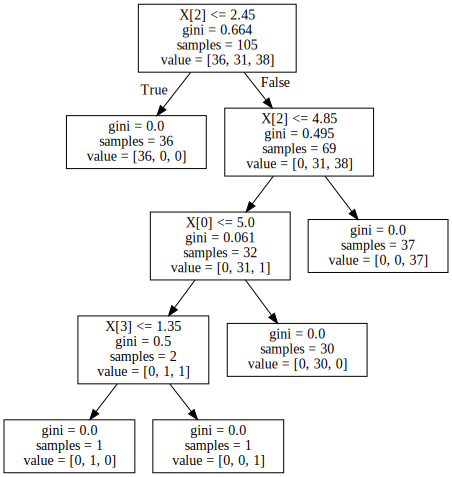

In [30]:
graphviz.Source(dot_graph)

In [24]:
dot_data  = export_graphviz(dt_clf, out_file=None)  # 生成.dot数据
graph = graphviz.Source(dot_data)  # 转为graph
graph.render('iris', format='png', view=True)  # 生成其他类型 默认会生成pdf

'iris.png'

----
参考代码：https://github.com/wzyonggege/statistical-learning-method

中文注释制作：机器学习初学者

微信公众号：ID:ai-start-com

配置环境：python 3.5+

代码全部测试通过。
![gongzhong](../gongzhong.jpg)